(2, 5000, 3, 3)
  0.107487 seconds (347.38 k allocations: 22.951 MiB, 71.55% compilation time)


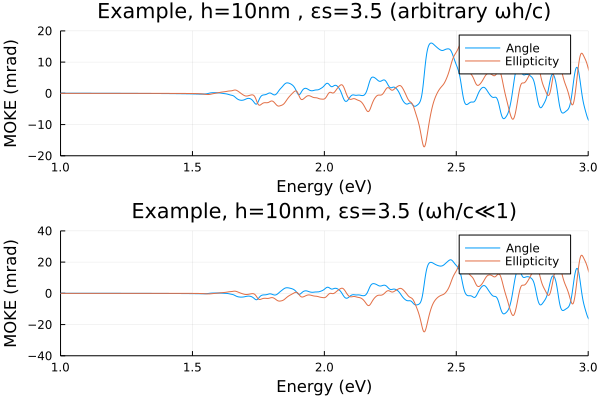

In [3]:
using HDF5
using Printf
using Plots

const h = 10.0  # sample thickness (nm)
const n3 = 3.5  # substrate refr. index, n3 = √ε_{subst.} 
const konst = 197.321   #  eV⋅nm
const myDir = ""
const myFile = "vaspout_rpa.h5"


function getEps(fname)
    w = Vector{Float64}
    eps = Array{Float64, 4}
try
    eps = h5read(fname,"results/linear_response/tdhf_dielectric_function")
    w = h5read(fname,"results/linear_response/tdhf_energies_dielectric_function")
catch
    eps = h5read(fname,"results/linear_response/density_density_dielectric_function")
    w = h5read(fname,"results/linear_response/energies_dielectric_function")
end
    return w, eps
end


function Theta_simple(ωh,n,Q)
    # ωh/c << 1
    theta = -2*n^2*Q*ωh / (n3^2 - 1)  
    return real(theta), imag(theta)
end


function Kerr_angles(ωh,n,Q)
#   k0h = h*ω/c
   r = 1im*zeros(2)
   i=0
   for σ in [+1,-1]
       i+=1
       nt = n * sqrt(1 + σ*Q)
       r_numer = 1 - n3 - (n3*nt^(-1) - nt) * tanh(1im*ωh*nt)
       r_denom = 1 + n3 - (n3*nt^(-1) + nt) * tanh(1im*ωh*nt)
       r[i] = r_numer / r_denom
   end        
    χ = r[1] / r[2]
    Arg = angle(χ)
    ϕK = Arg/2
    ψK = atan( (1 - abs(χ)) / (1 + abs(χ)) )
    return [ϕK, ψK]
end


function main()

w, eps = getEps(myDir*myFile)
nw = length(w)
println(size(eps))
    
epsxy_imag = [eps[2,:,3,2], -eps[2,:,2,3]]
epsxy_real = [eps[1,:,3,2], -eps[1,:,2,3]]
εxy = ( eps[1,:,3,2] - eps[1,:,2,3] ) / 2 + 1im*( eps[2,:,3,2] -eps[2,:,2,3] ) / 2  # antisym. part
εxx = eps[1,:,2,2] + 1im*( eps[2,:,2,2] ) 
n = sqrt.(εxx)                                 # n = √ε_{xx}
Q = -1im * εxy./εxx                            # Q = i ⋅ ε_{xy} / ε_{xx}
ωh = w*h / konst 
angle = zeros(nw)
ellipticity = zeros(nw)
    for i = 1:nw
       angle[i], ellipticity[i] = Kerr_angles(ωh[i],n[i],Q[i])
    end
a2 = zeros(nw)
e2 = zeros(nw)
    for i = 1:nw
       a2[i], e2[i] = Theta_simple(ωh[i],n[i],Q[i])
    end

outfile = "Kerr.dat"
f = open(outfile, "w")
        @printf(f,"%14s %18s %18s \n", "#Omega (eV)", "Kerr Angle (mrad)", "Ellipticity (mrad)")        
for i = 1:nw
        @printf(f,"%16.12f %16.12f %16.12f \n", w[i], angle[i]*1000, ellipticity[i]*1000)        
end

    
   p1= plot(w, 1000*[angle, ellipticity], xlims=(1,3),  ylims=(-20,20), label=["Angle" "Ellipticity"], title="Example, h=10nm , εs=3.5 (arbitrary ωh/c)", xlabel="Energy (eV)", ylabel=("MOKE (mrad)"))
   p2= plot(w, 1000*[a2, e2], xlims=(1,3), ylims=(-40,40), label=["Angle" "Ellipticity"], title="Example, h=10nm, εs=3.5 (ωh/c≪1)", xlabel="Energy (eV)", ylabel=("MOKE (mrad)"))

    plot(p1,p2,layout=(2,1))

#savefig("MOKE_plot.pdf")
    
end

@time main()